**In this tutorial you'll**:

1. **Learn what Stim is.**
2. **Install the `stim` python package.**
3. **Create a simple circuit, and sample from it.**
4. **Add detector annotations to a circuit, and sample them.**
5. **Generate example error correction circuits.**
6. **Combine Stim with PyMatching to correct the errors in a circuit.**
7. **Estimate the threshold of a repetition code.**
8. **Use `sinter` to speed the whole process up.**
9. **Estimate the threshold of a surface code.**

**Prereqs**:

This tutorial assumes you can read and write Python code, and that you have a working Python 3.7+ environment (perhaps you are reading this notebook in such an environment).

This tutorial assumes you understand what a quantum circuit is. For example, it assumes you know what a qubit is, what a Hadamard gate is, and what a CNOT gate is.

This tutorial assumes you are a *little* familiar with stabilizer circuits. For example, it assumes you've heard that they can be simulated cheaply and that they can represent protocols such as quantum error correction.

This tutorial assumes you are a *little* familiar with quantum error correcting codes. For example, it assumes you've heard the term "surface code" and "threshold".

# 1. What is Stim?

Stim is an [open source tool](https://github.com/quantumlib/Stim) for high performance analysis and simulation of quantum stabilizer circuits, with a focus on quantum error correction circuits.

Here is a plot from the [paper introducing Stim](https://doi.org/10.22331/q-2021-07-06-497), showing that Stim is thousands of times faster than other tools at sampling stabilizer circuits:

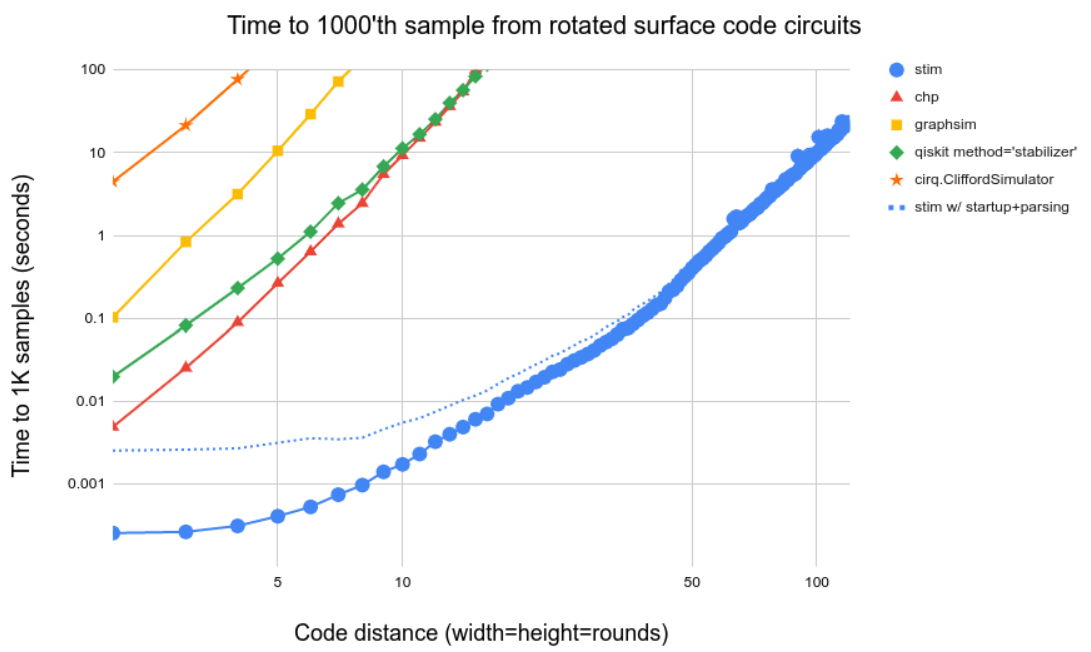

See also: the talk ["Software and the Honeycomb Code" from the weekly Duke/Pratt quantum computing seminar](https://www.youtube.com/watch?v=O3NaTGmY0Rw)

# 2. Install the Stim python package.

The first thing to do is to install and import stim.
Thanks to the python ecosystem, this is easy!
Stim is available as a pypi package, and can be installed using `pip install stim` and then imported with `import stim`.
Just like any other python package.

In [1]:
!pip install stim

In [2]:
import stim

# 3. Create a simple circuit, and sample from it.

In Stim, circuits are instances of the `stim.Circuit` class. You create a new empty circuit with `stim.Circuit()`, and add operations to it by calling `circuit.append(name_of_gate, list_of_targets)`.

You can find the name of the gate you want from the [stim gates reference](https://github.com/quantumlib/Stim/blob/main/doc/gates.md). Most of them are straightforward, like "H" for the Hadamard gate. Targets are just a number indicating a qubit. There's a qubit `0`, a qubit `1`, etc.

The first circuit you'll make is a circuit that prepares a Bell pair and then measures it:

In [3]:
circuit = stim.Circuit()

# First, the circuit will initialize a Bell pair.
circuit.append("H", [0])
circuit.append("CNOT", [0, 1])

# Then, the circuit will measure both qubits of the Bell pair in the Z basis.
circuit.append("M", [0, 1])

# Let's see the circuit's representation using stim's circuit language:
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
''')


You can sample from the circuit by using the `circuit.compile_sampler()` method to get a sampler object, and then calling `sample` on that object. For large circuits (thousands of qubits, millions of operations), it may take a few seconds to create the sampler (because it involves performing a stabilizer tableau simulation of the circuit to get a reference sample). Once the reference sample is acquired, the sampler is returned and samples can be acquired in bulk very cheapy.

Try taking 10 shots from the circuit:

In [6]:
sampler = circuit.compile_sampler()
print(sampler.sample(shots=10))

[[False False]
 [ True  True]
 [ True  True]
 [False False]
 [False False]
 [False False]
 [ True  True]
 [False False]
 [ True  True]
 [ True  True]]


Notice how there are ten rows (because you took ten shots) with two results per row (because there were two measurements in the circuit).
Also notice how the results are random from row to row, but always agree within each row.
That makes sense; that's what's supposed to happen when you repeatedly prepare and measure the |00> + |11> state.

# 4. Add detector annotations to a circuit, and sample them.

Stim circuits can include error correction annotations.
In particular, you can annotate that certain sets of measurements can be used to detect errors.
For example, in the circuit you created above, the two measurement results should always be equal.
You can tell Stim you care about that by adding a `DETECTOR` annotation to the circuit.

The `DETECTOR` annotation will take two targets: the two measurements whose parity you are asserting should be consistent from run to run. You point at the measurements by using the `stim.target_rec` method (short for "target measurement record"). The most recent measurement is `stim.target_rec(-1)` (also known as `rec[-1]` in stim's circuit language), and the second most recent measurement is `stim.target_rec(-2)`:

In [7]:
# Indicate the two previous measurements are supposed to consistently agree.
circuit.append("DETECTOR", [stim.target_rec(-1), stim.target_rec(-2)])
print(repr(circuit))

stim.Circuit('''
    H 0
    CX 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
''')


A slightly subtle point about detectors is that they only assert that the parity of the measurements is *always the same under noiseless execution*.
A detector doesn't say whether the parity should be even or should be odd, only that it should always be the same.
You annotate that a pair of measurements is always different in the same way that you annotate that a pair of measurements is always the same; it's the *consistency* that's key.

Anyways, now that you've annotated the circuit with a detector, you can sample from the circuit's detectors instead of sampling from its measurements.
You do that by creating a detector sampler, using the `compile_detector_sampler` method, and then calling `sample` on it.

In [8]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=5))

[[False]
 [False]
 [False]
 [False]
 [False]]


There are 5 rows in the results, because you took 5 shots.
There's one entry per row, because you put one detector in the circuit.

Notice how the results are always `False`.
The detector is never producing a detection event.
That's because there's no noise in the circuit; nothing to disturb the peace and quiet of a perfectly working machine.
Well... time to fix that!

Stim has a variety of error channels to pick from, like single qubit depolarization (`DEPOLARIZE1`) and phase damping (`Z_ERROR`), but in this context a good error to try is `X_ERROR`.
The `X_ERROR` noise channel probabilistically applies a bit flip (a Pauli X error) to each of its targets.
Note that each target is operated on independently.
They don't all flip together with the given probability, each one flips individually with the given probability.

You can recreate the circuit, with the noise inserted, by using Stim's domain specific language for circuits:

In [9]:
circuit = stim.Circuit("""
    H 0
    CX 0 1
    X_ERROR(0.2) 0 1
    M 0 1
    DETECTOR rec[-1] rec[-2]
""")

Now that you've put noise before the measurements, try sampling some more detector shots and see what happens:

In [10]:
sampler = circuit.compile_detector_sampler()
print(sampler.sample(shots=10))

[[ True]
 [False]
 [False]
 [False]
 [False]
 [False]
 [ True]
 [False]
 [ True]
 [ True]]


It's no longer all `False`s (...unless you got pretty lucky).
There are `True`s appearing amongst the `False`s.

The *detection fraction* of the circuit is how often detectors fire on average.
Given that an X error is being applied to each qubit with 20% probability, and the detector will fire when one of the qubits is hit (but not both), the detection fraction should be $0.8 \cdot 0.2 \cdot 2 = 0.32$.

You can estimate the detection fraction by just taking a lot of shots, and dividing by the number of shots and the number of detectors:

In [11]:
import numpy as np
print(np.sum(sampler.sample(shots=10**6)) / 10**6)

0.320312


As you can see, the estimated value is close to the expected value $0.32$.

# 5. Generate example error correction circuits.

Now it's time for you to work with a *real* error correcting circuit.
Well... a classical error correcting circuit.
The repetition code.

You could generate a repetition code circuit for yourself, but for the purposes of this tutorial it's easiest to use the example one included with Stim.
You can do this by calling `stim.Circuit.generated` with an argument of `"repetition_code:memory"`.
(You can find other valid arguments in the method's doc string, or just by passing in a bad one and looking at the exception message that comes out.)

Stim takes a few different parameters when generating circuits.
You have to decide how many times the stabilizers of the code are measured by specifying `rounds`, you have to decide the code distance by specifying `distance`, and you can specify what kind of noise to include using a few optional parameters.

To start with, you should just set `before_round_data_depolarization=0.03` which will insert a `DEPOLARIZE1(0.03)` operation targeting every data qubit at the start of each round of measuring the stabilizers of the code.
This is a "phenomenological noise model".

In [138]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=30,
    distance=9,
    before_round_data_depolarization=0.03)
print(repr(circuit))

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16
    TICK
    DEPOLARIZE1(0.03) 0 2 4 6 8 10 12 14 16
    CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    TICK
    CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
    TICK
    MR 1 3 5 7 9 11 13 15
    DETECTOR(1, 0) rec[-8]
    DETECTOR(3, 0) rec[-7]
    DETECTOR(5, 0) rec[-6]
    DETECTOR(7, 0) rec[-5]
    DETECTOR(9, 0) rec[-4]
    DETECTOR(11, 0) rec[-3]
    DETECTOR(13, 0) rec[-2]
    DETECTOR(15, 0) rec[-1]
    REPEAT 29 {
        TICK
        DEPOLARIZE1(0.03) 0 2 4 6 8 10 12 14 16
        CX 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
        TICK
        CX 2 1 4 3 6 5 8 7 10 9 12 11 14 13 16 15
        TICK
        MR 1 3 5 7 9 11 13 15
        SHIFT_COORDS(0, 1)
        DETECTOR(1, 0) rec[-8] rec[-16]
        DETECTOR(3, 0) rec[-7] rec[-15]
        DETECTOR(5, 0) rec[-6] rec[-14]
        DETECTOR(7, 0) rec[-5] rec[-13]
        DETECTOR(9, 0) rec[-4] rec[-12]
        DETECTOR(11, 0) rec[-3] rec[-11]
        DETECTOR(13, 0) rec[-

You can get a better view of the circuit by using the `stim.Circuit.diagram` method. The diagram type `timeline-svg` makes a picture of the operations applied by the circuit, and includes annotations showing how the DETECTORs declared in the circuit match up with measurements.

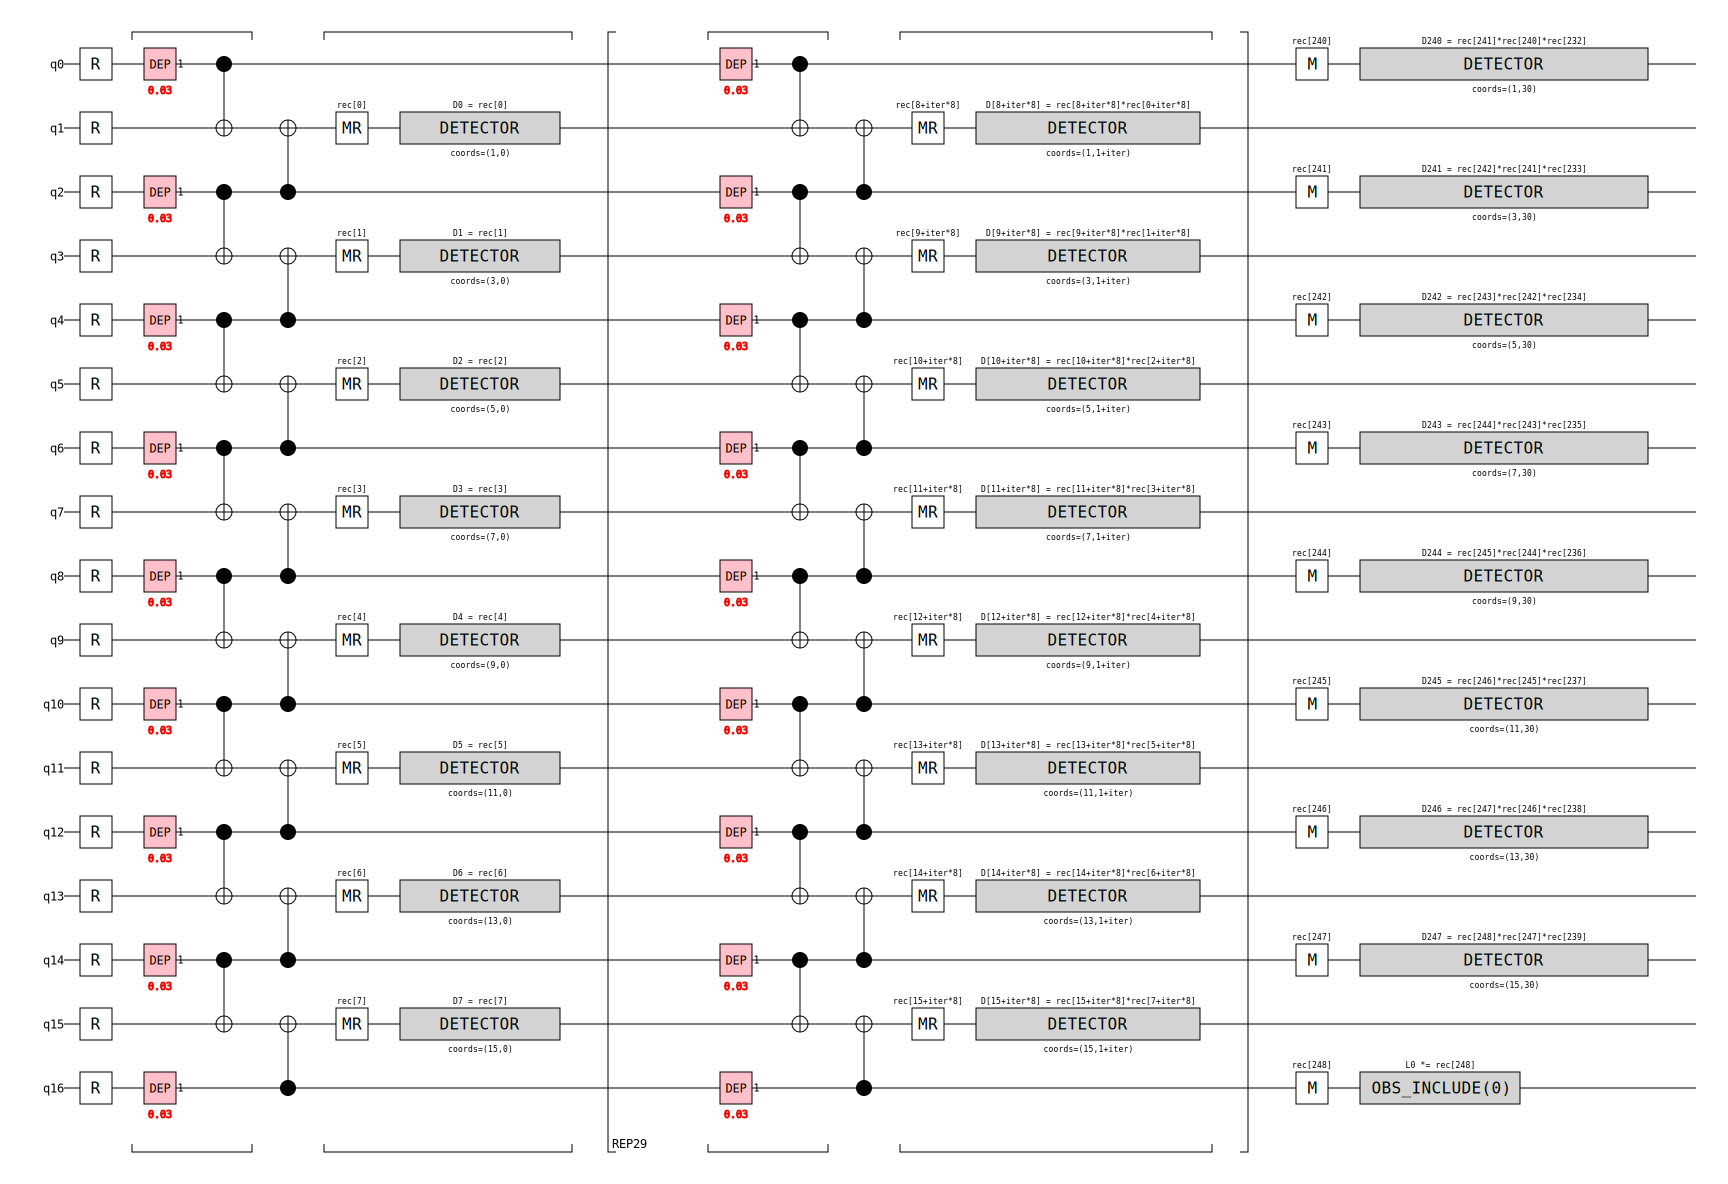

In [139]:
circuit.diagram(type="timeline-svg")

# Note: you can resize this image! Grab its bottom right handle.

The circuits generated by Stim include a lot of "nice to have" features.
The `DETECTOR` instructions, that annotate which measurements to compare, also include space and time coordinates.
These coordinates have no effect on the simulation, but are useful when debugging or drawing the circuit.
The generated circuits also have `TICK` annotations (which indicate divisions between layers of gates in the circuit), a `REPEAT` block (to avoid restating the same ten operations a hundred times), and an `OBSERVABLE_INCLUDE` instruction (identifying the measurement corresponding to the logical value preserved by the circuit).
Note that the repetition code is a bit unusual in that the protected observable corresponds to just one single measurement, instead of the parity of a set of measurements.

With the circuit in hand, you can try sampling from it.
Try sampling the measurements once, and printing out the results split up just right so that time advances from line to line:

In [140]:
sampler = circuit.compile_sampler()
one_sample = sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 8):
    timeslice = one_sample[k:k+8]
    print("".join("1" if e else "_" for e in timeslice))

________
________
1_______
1_______
_1_11___
_1_11___
_1_11___
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11_11
_1_11___
_1_11___
_1_11___
_1_11___
_1_11___
_1_1111_
_1_1111_
11__1_1_
_


See how the 1s seem to come in pairs of streaks?
That's because once a data qubit is flipped it stays flipped, and the measurements to its left and right permanently change parity.

If you sample the circuit's detectors, instead of its measurements, the streaks are replaced by spackle.
You get much sparser data:

In [141]:
detector_sampler = circuit.compile_detector_sampler()
one_sample = detector_sampler.sample(shots=1)[0]
for k in range(0, len(one_sample), 9):
    timeslice = one_sample[k:k+9]
    print("".join("!" if e else "_" for e in timeslice))

_________
_________
______!!_
_________
_________
_________
_________
_________
____!!___
_________
_________
_________
_______!!
_________
_________
_________
!________
_________
_____!___
_________
_________
_________
_________
_________
_________
_________
!!_______
_____


Notice how the `!`s tend to come in pairs, except near the sides.
This "comes in pairs" property is extremely important, because it allows you to perform error correction.
Every `!` must be paired with another `!`, with the left boundary, or with the right boundary.
In the circuit generated by Stim, the logical observable is annotated to be a measurement of the leftmost data qubit.
That data qubit was flipped once for each `!` that's paired with the left boundary.
If the data qubit was flipped an even number of times, the observable that was measured is correct.
If it was flipped an odd number of times, the observable that was measured needs to be flipped to be correct.
If you just had a syndrome decoder, you could use it to solve the matching problem and figure out if the leftmost data qubit (and therefore the protected logical observable) ended up flipped or not...

# 6. Combine Stim with PyMatching to correct the errors in a circuit.

Stim has a key feature that makes it easier to use a decoder: converting a circuit into a detector error model.
A detector error model is just a list of all the independent error mechanisms in a circuit, as well as their symptoms (which detectors they set off) and frame changes (which logical observables they flip).

You can get the detector error mode for a circuit by calling `circuit.detector_error_model()`:

In [142]:
print(repr(circuit.detector_error_model()))

stim.DetectorErrorModel('''
    error(0.02) D0
    error(0.02) D0 D1
    error(0.02) D1 D2
    error(0.02) D2 D3
    error(0.02) D3 D4
    error(0.02) D4 D5
    error(0.02) D5 D6
    error(0.02) D6 D7
    error(0.02) D7 L0
    detector(1, 0) D0
    detector(3, 0) D1
    detector(5, 0) D2
    detector(7, 0) D3
    detector(9, 0) D4
    detector(11, 0) D5
    detector(13, 0) D6
    detector(15, 0) D7
    repeat 28 {
        error(0.02) D8
        error(0.02) D8 D9
        error(0.02) D9 D10
        error(0.02) D10 D11
        error(0.02) D11 D12
        error(0.02) D12 D13
        error(0.02) D13 D14
        error(0.02) D14 D15
        error(0.02) D15 L0
        shift_detectors(0, 1) 0
        detector(1, 0) D8
        detector(3, 0) D9
        detector(5, 0) D10
        detector(7, 0) D11
        detector(9, 0) D12
        detector(11, 0) D13
        detector(13, 0) D14
        detector(15, 0) D15
        shift_detectors 8
    }
    error(0.02) D8
    error(0.02) D8 D9
    error(0.02) D

The detector error model format is easier for decoders to consume than a raw circuit, because everything is explained in terms of observable symptoms and hidden symptoms, which is how decoders usually conceptualize of the problem space.
For example, some decoders can be configured using a weighted graph, and `stim.DetectorErrorModel` is effectively just a weighted graph.
It might be a pain to write the glue code that converts the `stim.DetectorErrorModel` into exactly the right kind of graph expected by the decoder, but it's much easier than starting from the circuit or generating the graph from scratch and you only have to write that code once instead of once per circuit.

Instead of writing your own glue code, you'll use existing packages to glue stim to a decoder.
Specifically, you'll be using the [`pymatching`](https://github.com/oscarhiggott/PyMatching) python package as your decoder.
PyMatching is an open source minimum weight perfect matching decoder written by Oscar Higgott.
To explain stim circuits to pymatching, you'll be using the [`sinter`](https://github.com/quantumlib/Stim/tree/main/glue/sample) python package.
(Sinter is actually, technically, part of stim.
It's only a  separate python package to avoid creating a cyclic dependency between stim and pymatching, where each package wants to depend on the other.)

So, the first thing to do is to install `pymatching` and `sinter`:

In [ ]:
!pip install pymatching sinter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
import pymatching
import sinter
from typing import *

Now you're going to write a method for sampling and decoding from an arbitrary circuit, assuming it can be decoded by matching, by combining `stim` and `pymatching` using `sinter`.

First, you sample detection events from the circuit.
You do this by creating a sampler with `circuit.compile_detector_sampler()` and then calling `sampler.sample(shots, separate_observables=True)`.
The `separate_observables=True` argument is saying that you want the result of the method to be a tuple where the first entry is detection event data to give to the decoder and the second entry is the observable flip data the decoder is supposed to predict.

Second, you extract decoder information by using `stim.Circuit.detector_error_model(...)`.
The resulting detector error model will be used by sinter to configure pymatching.

Third, you run the decoder by calling `sinter.predict_observables_bit_packed`.
This method takes the detection event data and the detector error model.
It handles calling pymatching with this data for you.

Fourth, you compare the predictions made by pymatching to the actual observable flip data that was sampled.
Anytime the prediction differs, that's a logical error.

In [38]:
def count_logical_errors(circuit: stim.Circuit, num_shots: int) -> int:
    num_detectors = circuit.num_detectors
    num_observables = circuit.num_observables

    # Sample the circuit.
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)

    # Extract decoder configuration data from the circuit.
    detector_error_model = circuit.detector_error_model(decompose_errors=True)

    # Run the decoder.
    predictions = sinter.predict_observables(
        dem=detector_error_model,
        dets=detection_events,
        decoder='pymatching',
    )

    # Count the mistakes.
    num_errors = 0
    for actual_flip, predicted_flip in zip(observable_flips, predictions):
        if not np.array_equal(actual_flip, predicted_flip):
            num_errors += 1
    return num_errors


You can try this method on the repetition code circuit:

In [51]:
circuit = stim.Circuit.generated("repetition_code:memory", rounds=100, distance=9, before_round_data_depolarization=0.03)
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 4 wrong predictions (logical errors) out of 100000 shots


For contrast, compute the logical error rate achieved by just assuming that the logical observable is correct:

In [52]:
sampler = circuit.compile_detector_sampler()
_, observable_flips = sampler.sample(shots=num_shots, separate_observables=True)
naive_predictions = np.zeros_like(observable_flips);
num_naive_errors = 0
for actual_flip, predicted_flip in zip(observable_flips, naive_predictions):
    if not np.array_equal(actual_flip, predicted_flip):
        num_naive_errors += 1
print("there were", num_naive_errors, "wrong naive predictions out of", num_shots, "shots")

there were 48942 wrong naive predictions out of 100000 shots


As you can see, pymatching's prediction are much better than the naive approach.
Actually, with the physical error rate so low, pymatching is almost working *too* well.
There's a decent chance you didn't see any logical errors at all!

It's not very interesting for things to *always* work.
You should try bumping the physical error rate up from 3% to 13%:

In [144]:
circuit = stim.Circuit.generated(
    "repetition_code:memory",
    rounds=100,
    distance=9,
    before_round_data_depolarization=0.13)
num_shots = 100_000
num_logical_errors = count_logical_errors(circuit, num_shots)
print("there were", num_logical_errors, "wrong predictions (logical errors) out of", num_shots, "shots")

there were 4424 wrong predictions (logical errors) out of 100000 shots


Ah. The existence of failure. Perfect.

# 7. Estimate the threshold of a repetition code.

Estimating the threshold of an error correcting code really just comes down to trying a bunch of physical error rates and code distances.
You plot out the logical error rate vs physical error rate curve for each distance, and see where the curves cross.
That's where the physical error rate gets bad enough that increasing the distance starts to make the logical error rate worse, instead of better.
That's the threshold physical error rate.

Compute the threshold of the repetition code, for the specific type of noise you're using, by plotting the logical error rate at various code distances and physical error rates:

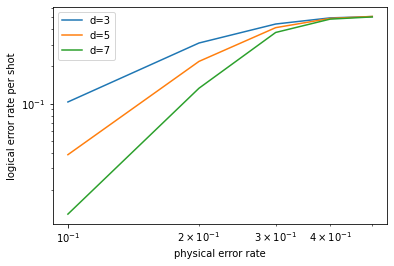

In [146]:
import matplotlib.pyplot as plt

num_shots = 10_000
for d in [3, 5, 7]:
    xs = []
    ys = []
    for noise in [0.1, 0.2, 0.3, 0.4, 0.5]:
        circuit = stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise)
        num_errors_sampled = count_logical_errors(circuit, num_shots)
        xs.append(noise)
        ys.append(num_errors_sampled / num_shots)
    plt.plot(xs, ys, label="d=" + str(d))
plt.loglog()
plt.xlabel("physical error rate")
plt.ylabel("logical error rate per shot")
plt.legend()
plt.show()

From the results here you can see that the repetition code has an amazingly high threshold! Somewhere around 30%-40%. Well... it's not *quite* so amazing when you remember that you're using a phenomenological noise model (instead of a circuit level noise model) and also that you're inserting depolarizing errors instead of bit flip errors (the repetition code is immune to Z errors, and when a depolarizing error occurs it's a Z error one third of the time).

Still, you can see that it's not so hard to try a few different cases and look for where lines cross.

# 8. Using sinter to speed the whole process up

Now that you understand the basic workflow of sampling from a circuit, making a decoder predict the observable flips, and plotting out the result, you should have sinter do almost the entire thing for you instead of doing it yourself.

If you convert your circuits into `sinter.Task` instances, you can give those tasks to `sinter.collect`.
Sinter will then spin up multiple worker processes to sample from and decode these circuits. `sinter.collect` takes a variety of useful options, such as the maximum number of shots to take and the number of workers to use.

In [59]:
tasks = [
    sinter.Task(
        circuit=stim.Circuit.generated(
            "repetition_code:memory",
            rounds=d * 3,
            distance=d,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'p': noise},
    )
    for d in [3, 5, 7, 9]
    for noise in [0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5]
]

collected_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=tasks,
    decoders=['pymatching'],
    max_shots=100_000,
    max_errors=500,
)

Sinter also has a `sinter.plot_error_rate` method which can be used to plot the logical error rates. In particular, this method automatically adds highlighted regions quantifying uncertainty in the estimates.

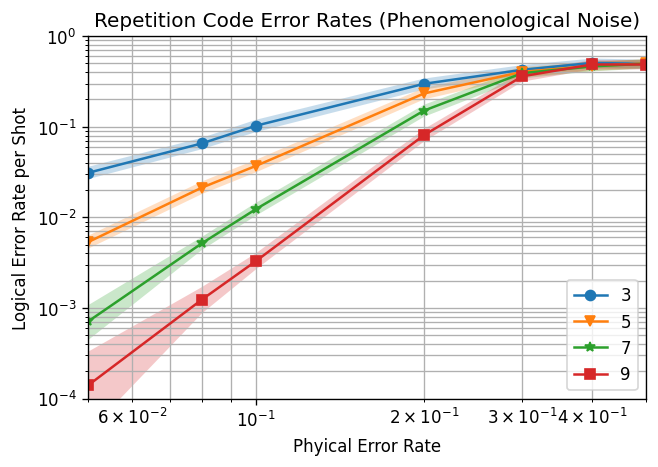

In [147]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
)
ax.set_ylim(1e-4, 1e-0)
ax.set_xlim(5e-2, 5e-1)
ax.loglog()
ax.set_title("Repetition Code Error Rates (Phenomenological Noise)")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Shot")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

# 9. Estimate the threshold of a surface code.

Estimating the threshold of a repetition code under phenomenelogical noise is one thing.
Estimating the threshold of a true quantum code, such as a surface code, under circuit noise, is...
well, historically, it would be a whole other thing.
But when using stim, and pymatching, and sinter, the workflow is exactly identical.
The only thing that changes are the circuits input into the process.

The hard part is making the circuits in the first place.
So, for this tutorial, you'll continue to lean on Stim's example circuits.
You can make simple surface code circuits using `stim.Circuit.generated`.

In [74]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=9,
    distance=3,
    after_clifford_depolarization=0.001,
    after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.001,
    before_round_data_depolarization=0.001)

Surface code circuits have a much more complex structure than repetition codes, because they are laid out in a 2d grid instead of a 1d line.
Try using `stim.Circuit.diagram(type="timeline-3d")` to see the spacetime structure of the circuit:

In [75]:
surface_code_circuit.without_noise().diagram(type="timeline-3d")

# This is an INTERACTIVE 3d viewer! Roll the mouse wheel to zoom in!
# Also it's resizable with the bottom-right tab.

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":12,"max":[0,0.5,0.5],"min":[0,-0.5,-0.5],"name":"cube","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":12,"max":[0.375,0.5625],"min":[0.3125,0.5],"name":"tex_coords_gate_R","type":"VEC2"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":12,"max":[0.125,0.5],"min":[0.0625,0.4375],"name":"tex_coords_gate_H","type":"VEC2"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.4,0.4],"min":[0,-0.4,-0.4],"name":"circle_loop","type":"VEC3"},{"bufferView":4,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.4,0.4],"min":[0,-0.4,-0.4],"name":"circle_loop","type":"VEC3"},{"bufferView":5,"byteOffset":0,"componentType":5126,"count":4,"max":[0,0.4,0.4],"min":[0,-0.4,-0.4],"name":"control_x_line_cross","type":"VEC3"},{"bufferView":6,"byteOffset":0,"componentType":5126,"count":12,"max":[0.4375,0.5625],"min":[0.375,0.5],"name":"tex_coords_gate_MR","type":"VEC2"},{"bufferView":7,"byteOffset":0,"componentType":5126,"count":12,"max":[0.3125,0.5625],"min":[0.25,0.5],"name":"tex_coords_gate_M","type":"VEC2"},{"bufferView":8,"byteOffset":0,"componentType":5126,"count":130,"max":[1,-32,-32],"min":[-17,-40.4853,-40.4853],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":9,"byteOffset":0,"componentType":5126,"count":30,"max":[0,-29.5,-31],"min":[-15.25,-41.4853,-41.4853],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":144,"byteOffset":0,"name":"cube","target":34962},{"buffer":1,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_R","target":34962},{"buffer":2,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_H","target":34962},{"buffer":3,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":4,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":5,"byteLength":48,"byteOffset":0,"name":"control_x_line_cross","target":34962},{"buffer":6,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_MR","target":34962},{"buffer":7,"byteLength":96,"byteOffset":0,"name":"tex_coords_gate_M","target":34962},{"buffer":8,"byteLength":1560,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":9,"byteLength":360,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":144,"name":"cube","uri":"data:application/octet-stream;base64,AAAAAAAAAD8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAC/AAAAAAAAAD8AAAC/AAAAAAAAAL8AAAA/AAAAAAAAAL8AAAA/AAAAAAAAAD8AAAC/AAAAAAAAAD8AAAA/"},{"byteLength":96,"name":"tex_coords_gate_R","uri":"data:application/octet-stream;base64,AADAPgAAAD8AAKA+AAAAPwAAwD4AABA/AACgPgAAAD8AAKA+AAAQPwAAwD4AABA/AADAPgAAED8AAMA+AAAAPwAAoD4AABA/AACgPgAAED8AAMA+AAAAPwAAoD4AAAA/"},{"byteLength":96,"name":"tex_coords_gate_H","uri":"data:application/octet-stream;base64,AAAAPgAA4D4AAIA9AADgPgAAAD4AAAA/AACAPQAA4D4AAIA9AAAAPwAAAD4AAAA/AAAAPgAAAD8AAAA+AADgPgAAgD0AAAA/AACAPQAAAD8AAAA+AADgPgAAgD0AAOA+"},{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":48,"name":"control_x_line_cross","uri":"data:application/octet-stream;base64,AAAAAM3MzL4AAAAAAAAAAM3MzD4AAAAAAAAAAAAAAADNzMy+AAAAAAAAAADNzMw+"},{"byteLength":96,"name":"tex_coords_gate_MR","u

Another useful type of diagram to view is a "detector slice diagram", which shows the locations of the stabilizers being measured by the circuit's detectors at a given time.

For example, you can use a detector slice diagram to see that, halfway through the measurement cycle of the surface code, its state is actually temporarily an even larger surface code!

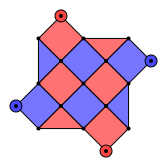

In [157]:
surface_code_circuit.diagram(
    type="detector-slice-svg", 
    tick=11,   # <--- look at different ticks to see the stabilizers change over time!
)

Notice that when you created this surface code circuit, you specified a lot more error parameters.
These parameters are adding full circuit noise, instead of just phenomenological noise.
Because the noise is richer, and because this is a quantum code instead of a classical code, the decoding problem is much harder and threshold is going to be noticeably lower.

Use `diagram(type="match-graph-3d")` to see the graph that `pymatching` would be configured with, to decode this surface code circuit.

In [77]:
surface_code_circuit.diagram(type="match-graph-3d")

# Click and drag to move the camera!

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":17,"max":[0,0.4,0.4],"min":[0,-0.4,-0.4],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":4102,"max":[18.6667,27.3704,36.54],"min":[-9.37043,-9.37043,-9.53998],"name":"buf_scattered_lines","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":718,"max":[27.3704,6,36.54],"min":[-0.666667,-0.666667,-9.53998],"name":"buf_red_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":204,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":49224,"byteOffset":0,"name":"buf_scattered_lines","target":34962},{"buffer":2,"byteLength":8616,"byteOffset":0,"name":"buf_red_scattered_lines","target":34962}],"buffers":[{"byteLength":204,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAOU1vT5Fvxw+AAAAAMPQkD7D0JA+AAAAAES/HD7lNb0+AAAAAPIwlrLNzMw+AAAAAEe/HL7lNb0+AAAAAMPQkL7D0JA+AAAAAOc1vb5Avxw+AAAAAM3MzL7yMBazAAAAAOU1vb5Evxy+AAAAAMHQkL7E0JC+AAAAADy/HL7nNb2+AAAAAPLkozHNzMy+AAAAAEm/HD7kNb2+AAAAAMbQkD6/0JC+AAAAAOY1vT5Evxy+AAAAAM3MzD4AAAAA"},{"byteLength":49224,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AAAAAAAAQEEAAAAAo4uuwEYXXUG66ALBAAAAAAAAQEEAAAAAAADAQAAAwEAAAAAAAAAAAAAAQEEAAAAAAAAAAAAAQEEAAEBAAADAQAAAwEAAAAAAAABAQQAAQEEAAAAAAADAQAAAwEAAAAAAAADAQAAAwEAAAEBAAADAQAAAwEAAAAAAAADAQAAAwEAAAEBAAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAADAQAAAwEAAAAAAAAAAAAAAQEEAAEBAAADAQAAAwEAAAAAAAAAAAAAAQEEAAEBAAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAABAQQAAQEEAAAAAgethQYHrYUHDoxjBAABAQQAAQEEAAAAAAACQQQAAwEAAAAAAAABAQQAAQEEAAAAAAACQQQAAwEAAAAAAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAQEEAAAAAAADAQAAAwEAAAEBAAABAQQAAQEEAAAAAAADAQAAAwEAAAEBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAQEEAAAAAAADAQAAAwEAAAEBAAABAQQAAwEAAAEBAAADAQAAAQEEAAEBAAABAQQAAQEEAAAAAAADAQAAAwEAAAEBAAADAQAAAQEEAAEBAunVWQJJiakH8scjAAABAQQAAQEEAAAAAAADAQAAAwEAAAEBAAADAQAAAQEEAAEBAunVWQJJiakH8scjAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAQEEAAAAAAAAAAAAAQEEAAEBAAABAQQAAQEEAAAAAAAAAAAAAQEEAAEBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAQEEAAAAAAAAAAAAAQEEAAEBAAADAQAAAQEEAAEBAunVWQJJiakH8scjAAABAQQAAQEEAAAAAAAAAAAAAQEEAAEBAAADAQAAAQEEAAEBAunVWQJJiakH8scjAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAQEEAAAAAAABAQQAAQEEAAEBAAABAQQAAQEEAAAAAAABAQQAAQEEAAEBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAQEEAAAAAAABAQQAAQEEAAEBAAABAQQAAwEAAAEBAAADAQAAAQEEAAEBAAACQQQAAwEAAAAAAAADAQAAAwEAAAEBAAACQQQAAwEAAAAAAAADAQAAAwEAAAEBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAACQQQAAwEAAAAAAAACQQQAAwEAAAEBAAACQQQAAwEAAAAAAAACQQQAAwEAAAEBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAACQQQAAwEAAAAAAAABAQQAAQEEAAEBAAACQQQAAwEAAAAAAAABAQQAAQEEAAEBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAADAQAAAAAAAAEBAAADAQAAAAAAAAMBAAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAADAQAAAwEAAAEBAAAAAAAAAQEEAAEBAAADAQAAAwEAAAEBAAAAAAAAAQEEAAEBAAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAADAQAAAwEAAAEBAAAAAAAAAQEEAAEBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAADAQAAAwEAAAEBAAAAAAAAAQEEAAEBAAADAQAAAQEEAAEBAunVWQJJiakH8scjAAADAQAAAwEAAAEBAAAAAAAAAQEEAAEBAAADAQAAAQEEAAEBAunVWQJJiakH8scjAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAADAQAAAwEAAAEBAAABAQQAAQEEAAEBAAADAQAAAwEAAAEBAAABAQQAAQEEAAEBAAABAQQAAwEAAAEBAAADAQAAAQEEAAEBAAADAQAAAwEAAAEBAAADAQAAAwEAAAMBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAwEAAAEBAAADAQAAAQEEAAEBAAABAQQAAwEAAAEBAAABAQQAAwEAAAMBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAQEEAAAAAgethQYHrYUHDoxjBAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAADAQAAAAAAAAEBA/VF4QASFy8CGcI3AAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAACQQQAAwEAAAEBAAABAQQAAQEEAAEBAAACQQQAAwEAAAEBAAABAQQAAQEEAAEBAAABAQQAAwEAAAEBAkmJqQbp1VkD8scjAAACQQQAAwEAAAEBAAACQQQAAwEAAAMBAAAAAAAAAQEEAAEBABIXLwIHrYUGGcI3AAAAAAAAAQEEAAEBAAAAAAAAAQEEAAMBAAAAAAAAAQEE

Now that you know how to make and inspect surface code circuits, the next step is to collect data from them.
Collection will take a bit longer this time, so you should specify `print_progress=True` to get progress updates while the collection runs.
Another useful argument (not used here) is `save_resume_filepath`, which allows you to cancel and restart collection without losing the work that was done.

In [99]:
surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7]
    for noise in [0.008, 0.009, 0.01, 0.011, 0.012]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=1_000_000,
    max_errors=10_000,
    print_progress=True,
)

Starting workers...
10 cases left
    case: processes=3  ~core_mins_left=1       shots_left=978266   errors_left=6890    {'d': 5, 'r': 15, 'p': 0.008}
    case: processes=1  ~core_mins_left=1       shots_left=999700   errors_left=9944    {'d': 5, 'r': 15, 'p': 0.009}
    case: processes=0  ~core_mins_left=None    shots_left=1000000  errors_left=10000   {'d': 5, 'r': 15, 'p': 0.01}
7 cases left
    case: processes=1  ~core_mins_left=1       shots_left=973000   errors_left=3012    {'d': 5, 'r': 15, 'p': 0.011}
    case: processes=3  ~core_mins_left=1       shots_left=997300   errors_left=9156    {'d': 5, 'r': 15, 'p': 0.012}
5 cases left
    case: processes=3  ~core_mins_left=1       shots_left=979600   errors_left=6774    {'d': 7, 'r': 21, 'p': 0.008}
    case: processes=1  ~core_mins_left=1       shots_left=999900   errors_left=9977    {'d': 7, 'r': 21, 'p': 0.009}
4 cases left
    case: processes=2  ~core_mins_left=1       shots_left=983874   errors_left=6634    {'d': 7, 'r': 21, 'p':

You can now plot the collected data.
Try using the `failure_units_per_shot_func` argument to plot per round error rates instead of per shot error rates.

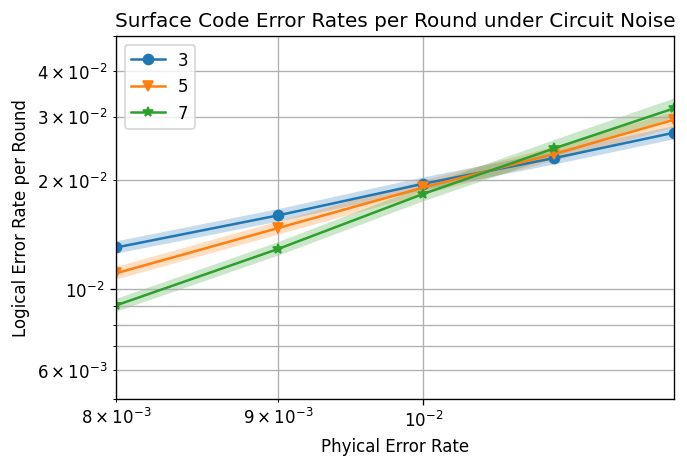

In [102]:
fig, ax = plt.subplots(1, 1)
sinter.plot_error_rate(
    ax=ax,
    stats=collected_surface_code_stats,
    x_func=lambda stats: stats.json_metadata['p'],
    group_func=lambda stats: stats.json_metadata['d'],
    failure_units_per_shot_func=lambda stats: stats.json_metadata['r'],
)
ax.set_ylim(5e-3, 5e-2)
ax.set_xlim(0.008, 0.012)
ax.loglog()
ax.set_title("Surface Code Error Rates per Round under Circuit Noise")
ax.set_xlabel("Phyical Error Rate")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

You can see from the plot that the threshold of the surface code is roughly 1%.

There is a problem here, though.
The problem is that the threshold isn't the only metric you care about.
The threshold tells you the absolute worse qubit quality that could possibly work, but it doesn't tell you how many of those qubits you would need to hit a target logical error rate.
What you **really** want to estimate is the quality *and corresponding quantity* of qubits needed to do fault tolerant computation.

Suppose, for the sack of example, that you have qubits with a physical error rate of 0.1% according to the noise model you are using.
Collect logical error rates from a variety of code distances so you can predict the code distance needed to achieve a target logical error rate.

In [133]:
noise = 1e-3

surface_code_tasks = [
    sinter.Task(
        circuit = stim.Circuit.generated(
            "surface_code:rotated_memory_z",
            rounds=d * 3,
            distance=d,
            after_clifford_depolarization=noise,
            after_reset_flip_probability=noise,
            before_measure_flip_probability=noise,
            before_round_data_depolarization=noise,
        ),
        json_metadata={'d': d, 'r': d * 3, 'p': noise},
    )
    for d in [3, 5, 7, 9]
]

collected_surface_code_stats: List[sinter.TaskStats] = sinter.collect(
    num_workers=4,
    tasks=surface_code_tasks,
    decoders=['pymatching'],
    max_shots=10_000_000,
    max_errors=100,
    print_progress=True,
)

Starting workers...
2 cases left
    case: processes=4  ~core_mins_left=2       shots_left=9969400  errors_left=99      {'d': 7, 'r': 21, 'p': 0.001}
    case: processes=0  ~core_mins_left=None    shots_left=10000000 errors_left=100     {'d': 9, 'r': 27, 'p': 0.001}
2 cases left
    case: processes=4  ~core_mins_left=1       shots_left=9714400  errors_left=81      {'d': 7, 'r': 21, 'p': 0.001}
    case: processes=0  ~core_mins_left=None    shots_left=10000000 errors_left=100     {'d': 9, 'r': 27, 'p': 0.001}
2 cases left
    case: processes=4  ~core_mins_left=1       shots_left=9298000  errors_left=65      {'d': 7, 'r': 21, 'p': 0.001}
    case: processes=0  ~core_mins_left=None    shots_left=10000000 errors_left=100     {'d': 9, 'r': 27, 'p': 0.001}
2 cases left
    case: processes=2  ~core_mins_left=1       shots_left=8884452  errors_left=38      {'d': 7, 'r': 21, 'p': 0.001}
    case: processes=2  ~core_mins_left=5       shots_left=9975700  errors_left=100     {'d': 9, 'r': 27, 'p':

To a good first approximation, logical error rates decrease exponentially with code distance.
Use scipy's linear regression to get a line fit of code distance versus log error rate.

In [136]:
import scipy

# Compute the line fit.
xs = []
ys = []
log_ys = []
for stats in collected_surface_code_stats:
    d = stats.json_metadata['d']
    if not stats.errors:
        print(f"Didn't see any errors for {d=}")
        continue
    per_shot = stats.errors / stats.shots
    per_round = sinter.shot_error_rate_to_piece_error_rate(per_shot, pieces=stats.json_metadata['r'])
    xs.append(d)
    ys.append(per_round)
    log_ys.append(np.log(per_round))
fit = scipy.stats.linregress(xs, log_ys)
print(fit)

LinregressResult(slope=-1.1785087760236768, intercept=-4.550701403571785, rvalue=-0.9998556670104807, pvalue=0.0001443329895193246, stderr=0.014159980025300587, intercept_stderr=0.09066811130156718)


Plot the collected points and the line fit, to get a projection of the distance needed to achieve a per-round error rate below one in a trillion.

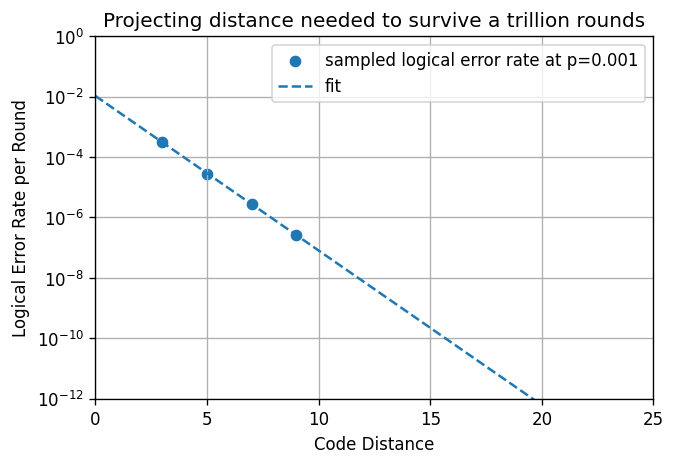

In [137]:
fig, ax = plt.subplots(1, 1)
ax.scatter(xs, ys, label=f"sampled logical error rate at p={noise}")
ax.plot([0, 25],
        [np.exp(fit.intercept), np.exp(fit.intercept + fit.slope * 25)],
        linestyle='--',
        label='fit')
ax.set_ylim(1e-12, 1e-0)
ax.set_xlim(0, 25)
ax.semilogy()
ax.set_title("Projecting distance needed to survive a trillion rounds")
ax.set_xlabel("Code Distance")
ax.set_ylabel("Logical Error Rate per Round")
ax.grid(which='major')
ax.grid(which='minor')
ax.legend()
fig.set_dpi(120)  # Show it bigger

Based on this data, it looks like a distance 20 patch would be sufficient to survive a trillion rounds.
That's a surface code with around 800 physical qubits.

That being said, please keep in mind that the footprint you just estimated is for a **specific realization of the surface code circuit**, using a **specific choice of circuit level noise**, and using **a specific kind of decoder**.

# End of Tutorial

Congratulations for making it this far! Historically, estimating the threshold of a quantum error correcting code under circuit noise would have taken weeks or months of work.
By leveraging open source tools, you just did it in a single sitting.
Nicely done!

# Additional Resources

If you ever get stuck using stim, get help by asking a question tagged `stim` on [the quantum computing stack exchange](https://quantumcomputing.stackexchange.com/).
You can also use the reference documentation:

- [Stim Python API Reference](https://github.com/quantumlib/Stim/blob/main/doc/python_api_reference_vDev.md)
- [Stim Supported Gates Reference](https://github.com/quantumlib/Stim/blob/main/doc/gates.md)
- [Stim Command Line Reference](https://github.com/quantumlib/Stim/blob/main/doc/usage_command_line.md)
- [Stim Circuit File Format (.stim)](https://github.com/quantumlib/Stim/blob/main/doc/file_format_stim_circuit.md)
- [Stim Detector Error model Format (.dem)](https://github.com/quantumlib/Stim/blob/main/doc/file_format_dem_detector_error_model.md)
- [Stim Results Format Reference](https://github.com/quantumlib/Stim/blob/main/doc/result_formats.md)

# Stim Circuits Available on Zenodo

If you're looking for interesting Stim circuits, there are some available on Zenodo, uploaded as the data accompanying papers:

- [Data for "A Pair Measurement Surface Code on Pentagons"](https://zenodo.org/record/6626417)
- [Data for "Stability Experiments: The Overlooked Dual of Memory Experiments"
](https://zenodo.org/record/6859486)
- [Data for "Benchmarking the Planar Honeycomb Code"
](https://zenodo.org/record/7072889)

There is also experimental data from real quantum computers, with accompanying stim circuits for each case.
You can use stim and pymatching to decode this data for yourself:

- [Data for "Suppressing quantum errors by scaling a surface code logical qubit"
](https://zenodo.org/record/6804040)